# Depression recognition using facial expression

In [1]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
import warnings
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

<h1 id="1"> <center>2. Loading the data</center> </h1> <a id="2"></a>

In [2]:
data = pd.read_csv("./fer2013.csv")
data.shape

(35887, 3)

To see the dataset has any missing values.

In [3]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


<h1 id="1"> <center>3. Data pre-processing</center> </h1> <a id="3"></a>

In [62]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', '0', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## 3.1 Shuffling the data




Firstly, we will shuffle the data using sample() function and determining fraction as 1 to shuffle the data by changing the rows.

In [63]:
data = data.sample(2000)

## 3.2 One Hot Encoding

Then, we will do one hot encoding operation to change the categorical labels as numeric labels to learning algorithm can work better in predictions process.

In [64]:
labels = to_categorical(data[['emotion']], num_classes=7)

Changing image pixels to Numpy array


In [65]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

## 3.3 Standardization

We will change the data structure to feed the standart scaler to implement standardization process to our data. Since StandartScaler() function only takes 2 dimensional array we will reshape the data then apply our scaler to make the mean zero and standart deviation as unit. 

 

In [66]:
pixels = train_pixels.reshape((2000*2304,1))

In [67]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

## 3.4 Reshaping the data (48,48)


After that, we will reshape the data to make our image pixels ready to split operation. 

In [68]:
pixels = train_pixels.reshape((2000, 48, 48,1))

## 3.5 Train test validation split


Now, we have 35887 images with each containing 48x48 pixels. We will split the data into train,test and Validation data to feed and evaluate and validate our data with the ratio of 10%.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [70]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1620, 48, 48, 1)
(200, 48, 48, 1)
(180, 48, 48, 1)


We can see some train data containing one sample of each class with the help of this plot code.

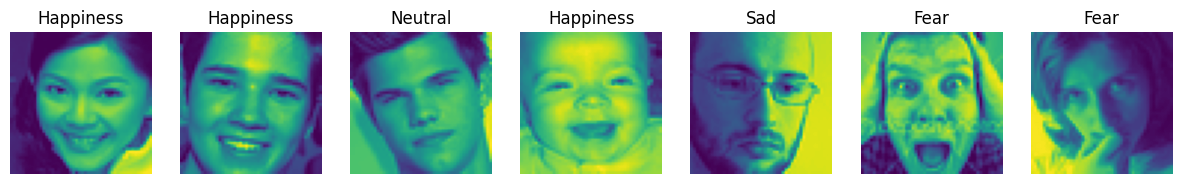

In [71]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

## 3.6 Data augmentation using ImageDataGenerator

We can do data augmentation to have more data to train and validate our model to prevent overfitting. Data augmentation can be done on training and validation sets as it helps the model become more generalize and robust.

In [72]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [73]:
datagen.fit(X_train)
valgen.fit(X_val)

In [74]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

Our dataset is ready to feed our model. We will look at our model architecture.

<h1 id="1"> <center>4.  Design a model </center> </h1> <a id="4"></a>

## 4.1 CNN model

CNN model has many layers with different units such as Convolutional layer, Max pooling layer, Batch normalization and Drop out layer to regularize the model.

In [75]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [76]:
model = cnn_model()

Then, we compile our model with Adam optimizer with 0.0001 learning rate and chose metric as accuracy, then loss as categorical crossentropy

In [77]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 128)      

## 4.2 Early stopping

Adding checkpointer to implement Early Stopping to prevent overfitting.

In [79]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [80]:
history = model.fit(train_generator,
                    epochs=10,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 15.0307 - accuracy: 0.1574
Epoch 1: val_accuracy improved from -inf to 0.12222, saving model to best_model.h5
26/26 [==============================] - 62s 2s/step - loss: 15.0307 - accuracy: 0.1574 - val_loss: 14.2562 - val_accuracy: 0.1222
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 14.9397 - accuracy: 0.1599
Epoch 2: val_accuracy did not improve from 0.12222
26/26 [==============================] - 49s 2s/step - loss: 14.9397 - accuracy: 0.1599 - val_loss: 14.2273 - val_accuracy: 0.1222
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 14.8258 - accuracy: 0.1679
Epoch 3: val_accuracy improved from 0.12222 to 0.15000, saving model to best_model.h5
26/26 [==============================] - 52s 2s/step - loss: 14.8258 - accuracy: 0.1679 - val_loss: 14.1463 - val_accuracy: 0.1500
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 14.6970 - accuracy: 0.1698
Epoch 4

## 4.3 Visualizing results

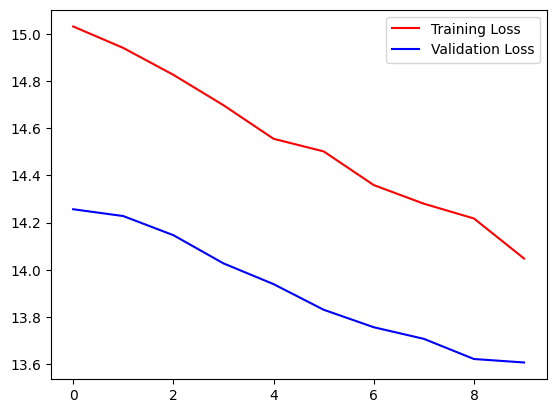

In [81]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

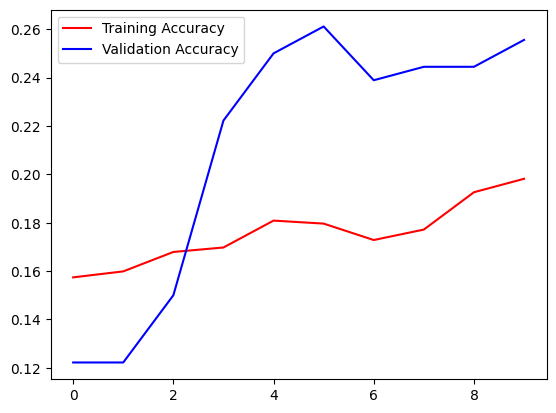

In [82]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [83]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

7/7 [==============================] - 1s 137ms/step - loss: 13.5628 - accuracy: 0.2200
Test Acc: 0.2199999988079071


In [84]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

7/7 [==============================] - 6s 150ms/step


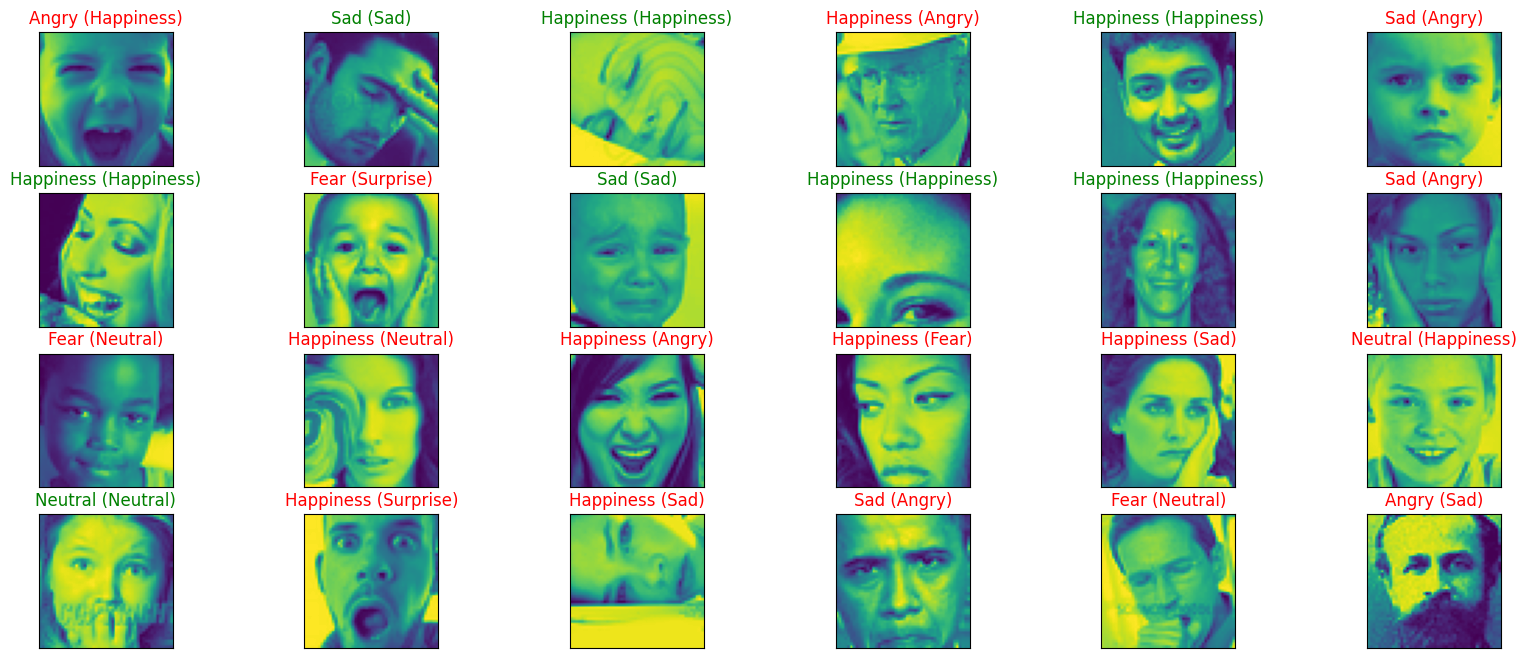

In [85]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

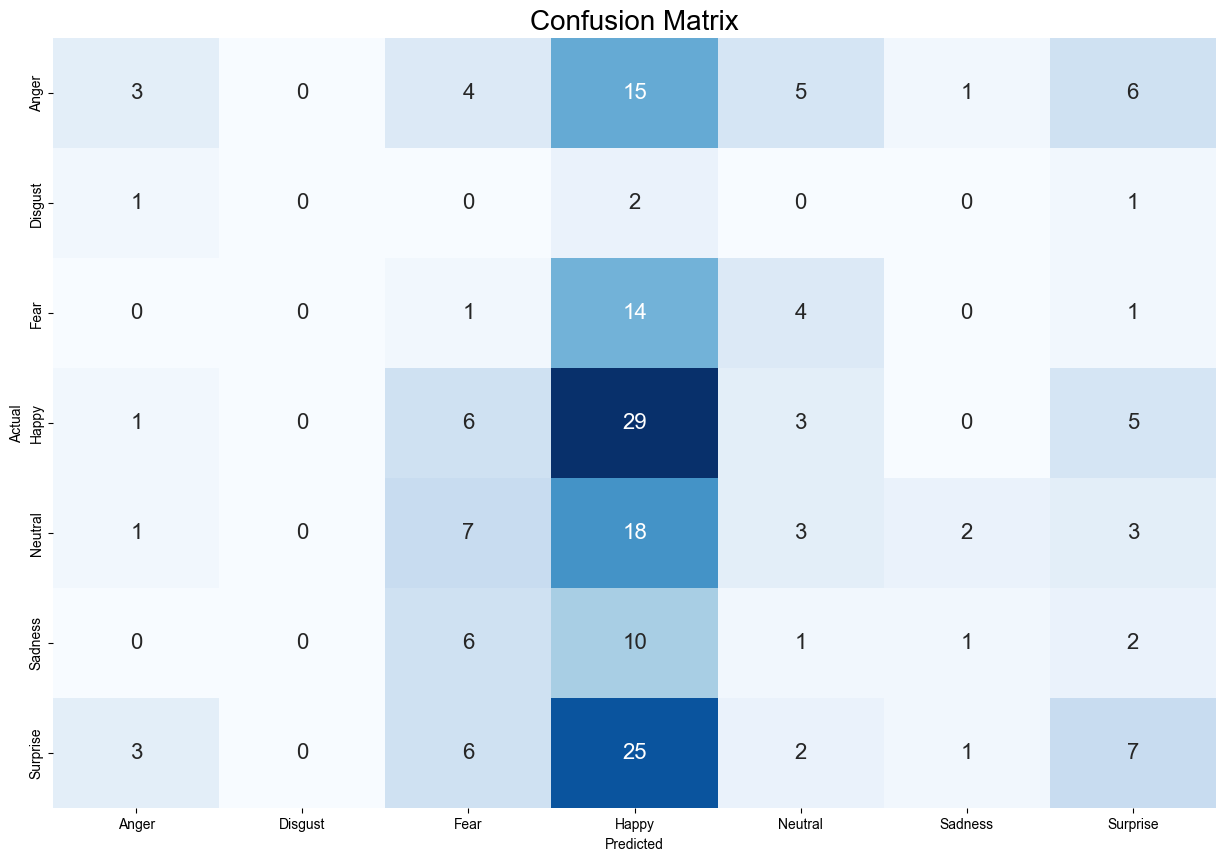

In [86]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [87]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.333     0.088     0.140        34
           1      0.000     0.000     0.000         4
           2      0.033     0.050     0.040        20
           3      0.257     0.659     0.369        44
           4      0.167     0.088     0.115        34
           5      0.200     0.050     0.080        20
           6      0.280     0.159     0.203        44

    accuracy                          0.220       200
   macro avg      0.181     0.156     0.135       200
weighted avg      0.226     0.220     0.181       200



<h1 id="1"> <center>5. Fine tuning</center> </h1> <a id="5"></a>

## 5.1 Changing optimizer

Changing Optimizer to Stochastic Gradient Descent (SGD)

In [88]:
model = cnn_model()

In [89]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [90]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 15.0893 - accuracy: 0.1228
Epoch 1: val_accuracy did not improve from 0.26111
26/26 [==============================] - 46s 2s/step - loss: 15.0893 - accuracy: 0.1228 - val_loss: 14.2937 - val_accuracy: 0.1611
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 14.9881 - accuracy: 0.1611
Epoch 2: val_accuracy did not improve from 0.26111
26/26 [==============================] - 42s 2s/step - loss: 14.9881 - accuracy: 0.1611 - val_loss: 14.2527 - val_accuracy: 0.1167
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 14.9533 - accuracy: 0.1543
Epoch 3: val_accuracy did not improve from 0.26111
26/26 [==============================] - 42s 2s/step - loss: 14.9533 - accuracy: 0.1543 - val_loss: 14.2935 - val_accuracy: 0.0389
Epoch 4/30
26/26 [==============================] - ETA: 0s - loss: 14.8870 - accuracy: 0.1654
Epoch 4: val_accuracy did not improve from 0.26111
26/26 [================

In [91]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

7/7 [==============================] - 1s 130ms/step - loss: 14.2353 - accuracy: 0.1750
Test Acc: 0.17499999701976776


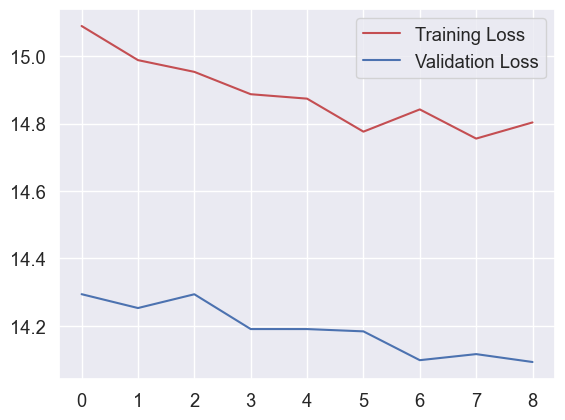

In [92]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

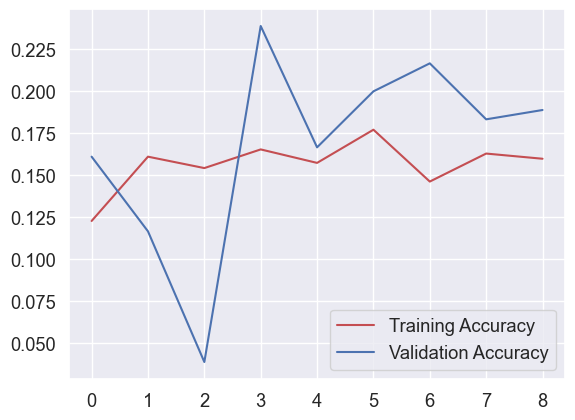

In [93]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

The model trained with SGD did not give better results than Adam optimizer.

## 5.2 Changing epoch number

Let's change the epoch number as 50 for the cnn_model.

In [94]:
model = cnn_model()

In [95]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [96]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [97]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 15.0350 - accuracy: 0.1648
Epoch 1: val_accuracy improved from -inf to 0.12778, saving model to best_model.h5
26/26 [==============================] - 46s 2s/step - loss: 15.0350 - accuracy: 0.1648 - val_loss: 14.4951 - val_accuracy: 0.1278
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 14.9345 - accuracy: 0.1512
Epoch 2: val_accuracy improved from 0.12778 to 0.16111, saving model to best_model.h5
26/26 [==============================] - 41s 2s/step - loss: 14.9345 - accuracy: 0.1512 - val_loss: 14.1834 - val_accuracy: 0.1611
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 14.7946 - accuracy: 0.1660
Epoch 3: val_accuracy improved from 0.16111 to 0.23889, saving model to best_model.h5
26/26 [==============================] - 42s 2s/step - loss: 14.7946 - accuracy: 0.1660 - val_loss: 14.0394 - val_accuracy: 0.2389
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss:

In [98]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

7/7 [==============================] - 1s 133ms/step - loss: 13.9426 - accuracy: 0.2550
Test Acc: 0.2549999952316284


In [99]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

7/7 [==============================] - 1s 134ms/step


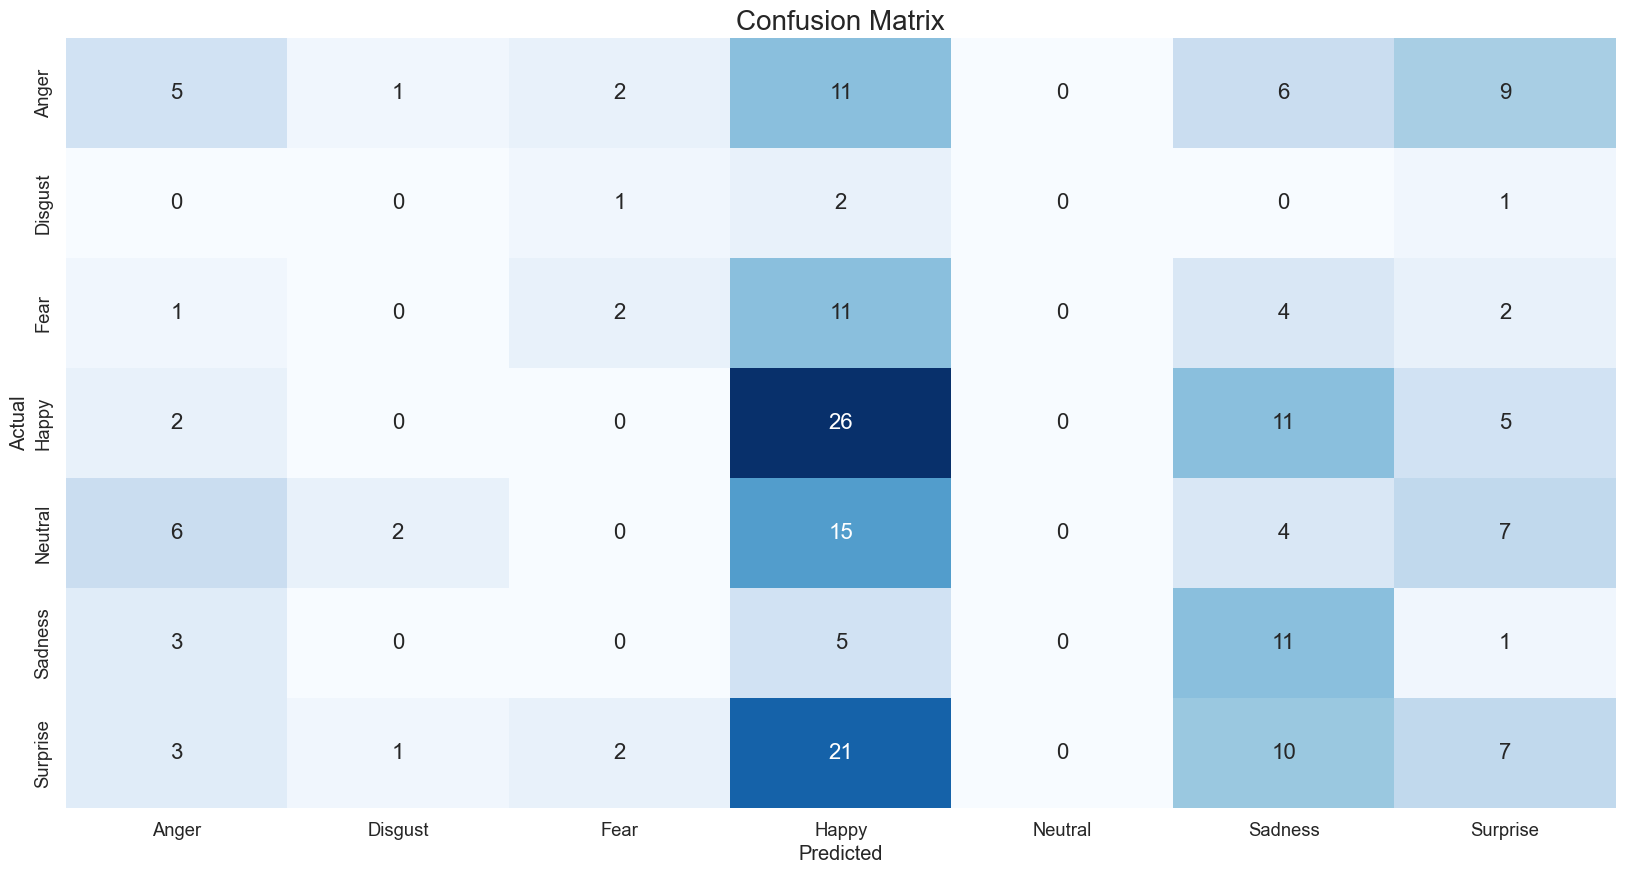

In [100]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [101]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.250     0.147     0.185        34
           1      0.000     0.000     0.000         4
           2      0.286     0.100     0.148        20
           3      0.286     0.591     0.385        44
           4      0.000     0.000     0.000        34
           5      0.239     0.550     0.333        20
           6      0.219     0.159     0.184        44

    accuracy                          0.255       200
   macro avg      0.183     0.221     0.177       200
weighted avg      0.206     0.255     0.205       200



The model trained with 50 epochs has better results than the model trained with 30 epochs.